In [1]:
import os

import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from scripts.models import *
from scripts.dataloader import *
from scripts.layers import *

In [6]:
checkpoint_dir = "experiments/dataaug_all/lightning_logs/version_2/checkpoints/epoch=374.ckpt"
n = 10
size = 1024
bs = 256

In [280]:
model = GAN.load_from_checkpoint(checkpoint_dir).to("cuda:0")
model.eval()

GAN(
  (generator): BasicGenerator(
    (l1): Linear(in_features=100, out_features=4096, bias=True)
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (5): Upsample(scale_fac

In [4]:
y = []
X = []

with th.no_grad():
    for i in range(n):
        z = th.normal(0, 1, (size, model.hparams.latent_dim), device=model.device)
        x = model.generator(z)

        y.append(z)
        X.append(x)

y = th.cat(y, axis=0)
X = th.cat(X, axis=0)
y.shape, X.shape

(torch.Size([10240, 100]), torch.Size([10240, 3, 32, 64]))

In [7]:
dataset = TensorDataset(X.detach().cpu(), y.detach().cpu())
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

In [8]:
class EncoderLatent(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            ConvBlock(3, 32, use_bn=True),
            nn.MaxPool2d(2,2),
            ConvBlock(32, 64, use_bn=True),
            nn.MaxPool2d(2,2),
            ConvBlock(64, 128, use_bn=True),
            nn.MaxPool2d(2,2),
            ConvBlock(128, 256, use_bn=True),
            nn.MaxPool2d(2,2)
        )
        
        self.l1 = nn.Linear(2*4*256, 100)
    
    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.shape[0], -1)
        x = self.l1(x)
        return x

In [9]:
net = EncoderLatent().cuda()
optimizer = th.optim.Adam(net.parameters(), lr=0.001)
loss = th.nn.MSELoss(reduction="mean")

In [11]:
net.train()
learning_curve = []
for i in range(1, 200):
    l = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        y_p = net.forward(x.cuda())
        output = loss(y_p, y.cuda())
        l += output.item()
        output.backward()
        optimizer.step()
    
    learning_curve.append(l / len(dataloader))
    if i % 10 == 0:
        print("iteration ", i, "loss", l / len(dataloader))
    
    if i % 90 == 0:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
            
th.save(net.state_dict(), "experiments/gan_inversion/net.pkl")

iteration  10 loss 0.5701038524508476
iteration  20 loss 0.46596389785408976
iteration  30 loss 0.392927223443985
iteration  40 loss 0.3485002018511295
iteration  50 loss 0.3141316339373589
iteration  60 loss 0.28951241746544837
iteration  70 loss 0.26863467395305635
iteration  80 loss 0.25347248539328576
iteration  90 loss 0.23726159073412417
iteration  100 loss 0.19105645045638084
iteration  110 loss 0.18804034031927586
iteration  120 loss 0.18712375834584236
iteration  130 loss 0.1854029718786478
iteration  140 loss 0.184613586217165
iteration  150 loss 0.18307697661221028
iteration  160 loss 0.18208957985043525
iteration  170 loss 0.17833616212010384
iteration  180 loss 0.17727105058729647
iteration  190 loss 0.1712871503084898


Text(0, 0.5, 'MSE')

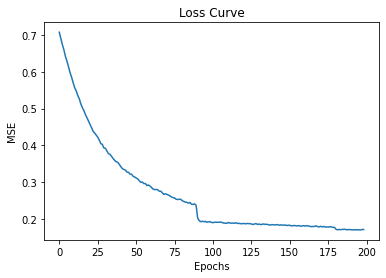

In [276]:
l = [ll / len(dataloader) for ll in learning_curve]
plt.plot(l)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [279]:
net.load_state_dict(th.load("experiments/gan_inversion/net.pkl"))
net.cuda()
net.eval()

EncoderLatent(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv_block): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv_block): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (conv_block): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=0

([], [])

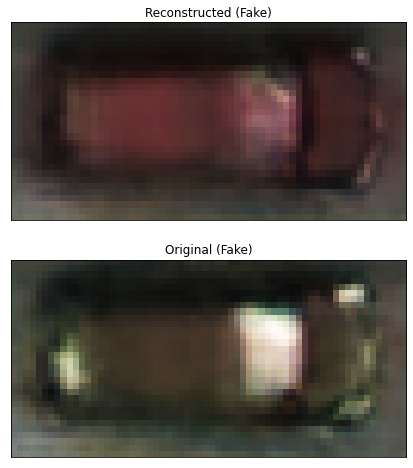

In [290]:
# testing
with th.no_grad():
    z = th.normal(0, 1, (1, model.hparams.latent_dim), device=model.device)
    x_orig = model.generator(z)

    z_rec = net.forward(x_orig)
    x_rec = model.generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])

([], [])

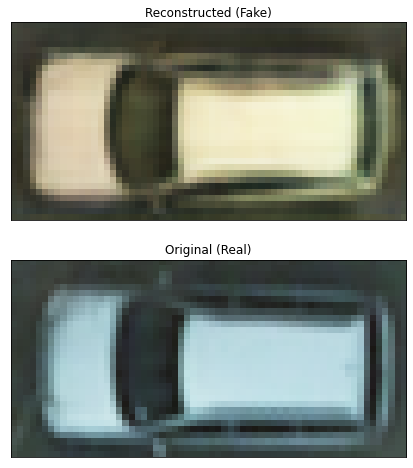

In [296]:
# real image
import cv2
r, c = 32, 64
cars = np.load("../potsdam_data/potsdam_cars/cars.npy", allow_pickle=True)

cars_resized = []
for car in cars:
    car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)
    cars_resized.append(2*(car_resized / 255) - 1)

i = 858
# i = 2110
with th.no_grad():
    x_orig = th.unsqueeze(th.tensor(cars_resized[i]), axis=0)
    z_rec = net.forward(x_orig.cuda())
    x_rec = model.generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Real)", fontsize=12)
plt.xticks([])
plt.yticks([])